Let's see if we can solve a differential equation using simulated annealing.


The idea is simple. Assume you have a differential equation of the form (the same arguments can be applied for PDEs)
$$
\dfrac{dy}{dt} =  G(t,y) 
$$
with an initial condition $y_0 = y(0)$, and a guess for $y(t)$ that depends on a number of free parameters. Denoting this guess as $\tilde{y}(t ; \{a\})$, find the values of $\{a\}$ tha minimize 

$$C(\{a\}) = \Big|y_0 - \tilde{y}(0,\{a\})\Big|+ \sum_i \Big| \dfrac{d\tilde{y}}{dt} -  G(t,\tilde{y}) \Big|_{t=t_i}  \;,$$
with $i$ running in a number of time points we wish to know the solution.

Since we would like to find a solution with $C \approx 0$, we can terminate the anealing process once $C < tol$. 

In [1]:
import numpy as np

import matplotlib
#matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt

import SimulatedAnnealing as SA

Let's see how it works for 
$$
\dfrac{dy(t)}{dt}= t \, y(t)
$$

with a guess

$$
\tilde{y}(t,\{a\}) = \sum_i a_i \ t^i
$$


Keep in mind that exact solution of this is

$$
y(t)= y_0 \ e^{\frac{1}{2} \ t^2} \;.
$$



Practically, this kind of solution is very inefficient for simple ODEs. Perhaps  for larger systems of even for PDEs it can be better.


In [2]:
class ODE:
    def __init__(self,guess,rhs,time_steps,y0,dim):
        
        self.guess=guess
        self.rhs=rhs
        
        self.time_steps=time_steps
        self.y0=y0
        self.dim=dim
        
        
        # basically the number of constraints. Will be used to determine the MSE
        self.size=float(len(time_steps))
        
    def lhs(self,t,a,h=1e-8):
        return (self.guess(t+h,a) - guess(t-h,a))/(2*h) 
    
    def MSE_Cost(self,a):
        
        #match the lhs with the rhs
        c=np.sum( [(self.lhs(t,a)-self.rhs(t,a))**2 for t in self.time_steps ] )/self.size
        
        #c=np.sum( (self.lhs(self.time_steps,a)-self.rhs(self.time_steps,a))**2 )/self.size
        
        #match the initial condition
        c+=( self.y0-self.guess(self.time_steps[0],a))**2
        
        return c*0.5 #basically the same weight for the initial condition as the other constraints
    
    def Log_Cost(self,a):

        #match the lhs with the rhs
        c=np.sum( [ (self.lhs(t,a)-self.rhs(t,a))**2  for t in self.time_steps ] )
        c=c/self.size
        #match the initial condition
        c+= (self.y0-self.guess(self.time_steps[0],a))**2

        c=np.log(1+c*0.5)
        
        return c**2
    
    def Rel_Cost(self,a):
        scale=np.mean(  [ self.rhs(t,a)**2  for t in self.time_steps ] )
        #match the lhs with the rhs
        c=np.sum( [ (self.lhs(t,a)-self.rhs(t,a))**2  for t in self.time_steps ] )
        #match the initial condition
        c+= (self.y0-self.guess(self.time_steps[0],a))**2

        c=c*0.5
        
        return c
    
    def LogCosh_Cost(self,a):
        
        #match the lhs with the rhs
        c=np.sum( [np.log( np.cosh(self.lhs(t,a)-self.rhs(t,a)) ) for t in self.time_steps ] )/self.size
        
        #c=np.sum( (self.lhs(self.time_steps,a)-self.rhs(self.time_steps,a))**2 )/self.size
        
        #match the initial condition
        c+=np.log(np.cosh( self.y0-self.guess(self.time_steps[0],a) )) 
        
        return c*0.5 #basically the same weight for the initial condition as the other constraints



In [7]:
dim=4
y0=1e0
time=np.linspace(0,1,50)

def guess(t,a):
#     return a[0]*np.exp(a[1]*t**2)
    return  np.sum( [ a[i]*t**i for i in range(dim) ] )


def rhs(t,a):
    return guess(t,a)*t


diffeq=ODE(guess,rhs,time,y0,dim)


a0= np.zeros(dim) 
# a0= np.random.rand(dim)

T0=diffeq.MSE_Cost(a0)*10+1e-2# the temperature should be high enough to start in a nice hot position

k=0.9
IterationT=50

MinT=0
# MinT=1e-50

sigma=1e-1

tol=1e-5

Nstar=100

Sim=SA.SimulatedAnnealing(diffeq.MSE_Cost, dim , a0 ,  T0, k, IterationT, MinT,sigma,tol,Nstar)

a,_=Sim.run()

<IPython.core.display.Javascript object>


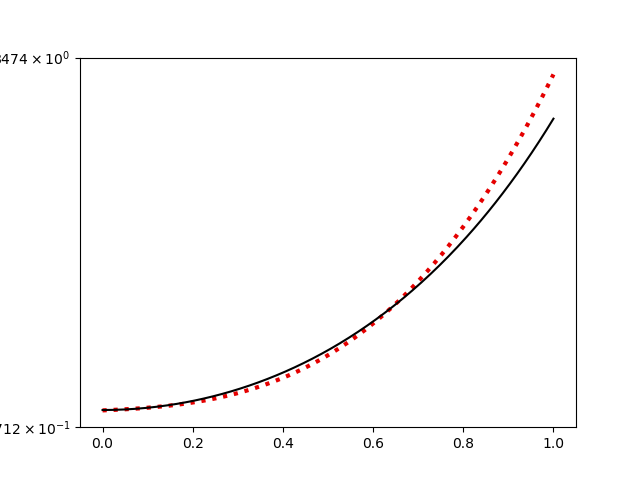

In [9]:
x=np.linspace(0,1,250)

# plt.plot(x,[guess(_t,a) -guess(time[0],a) +y0 for _t in x ],linestyle='--',linewidth=3.5,c='xkcd:blue')
plt.plot(x,[guess(_t,a) for _t in x ],linestyle=':',linewidth=3,c='xkcd:red')

plt.plot(x,  y0*np.exp(0.5*x**2),c='xkcd:black' )

plt.yscale('symlog')

plt.show()